## NDWI and NDVI Geospatial Processing

This script is an effort to take a common water-resources task (estimating water cover and vegetation cover from satellite data for a change-over-time analysis) that is typically performed via ESRI ArcGIS and a few other steps and fully automate it an open-source setting using only Python programming.



In [1]:
# Basic stuff
import sys, traceback, datetime, warnings

# Geoprocessing
import gdal
import geopandas as gpd
import pandas as pd
import numpy
import ogr
import osr
from shapely.geometry import Point

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
plt.ion()

# Web Scraping
import requests as r
import getpass, pprint, time, os, cgi, json

/tmp/ipykernel_203642/4034116258.py:15: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
# Available datasets:
# MODIS is 2001-present every 8 days, @ 500m resolution in a ~1200kmx1200km snapshot, over 100% of planet
# LANDSAT goes back to the 70s I think but is biweekly @ various resolutions and 
# snapshot sizes due to different sizes (Landsat 4-5 versus 7 or 8-9), and is mostly CONUS (lower 48) except newer stuff

# Input definitions:
tempStorage = "TempFiles"
outputStorage = "Outputs"
zone_shp = "Inputs/Sample_AOI.shp"
startDate = "01-01-2022" # Try to put this at least 3 weeks before you need to account for missing data
endDate = "01-01-2023" # Try to put this at least 3 weeks after you need to account for missing data
data_source = "MODIS"
jobPrefix = "Test"
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  # Set the AρρEEARS API to a variable
username = os.environ['Craigs_Earthdata_user'] #backend variable
password = os.environ['Craigs_Earthdata_pass'] #backend variable

In [3]:
# Dataset definitions
data_defs = {
    "MODIS": {
        "productsAndLayers": [
            {
                "layer": 'ET_500m',
                "product": 'MOD16A2.061'
            }
        ]
    }
}
MODISGridShp = "Inputs/modis_grid_WGS84.shp"

In [4]:
# Debug funcion definition
def debugMsg(inMsg): # Logs a message to the screen with the current date/time
    curTime = str(datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    print(curTime+" | "+inMsg)

In [5]:
# MODIS-specific functions:
def openConn(api,username,password):
    token_response = r.post(
            '{}login'.format('https://appeears.earthdatacloud.nasa.gov/api/'), 
            auth=(username, password)
        ).json() # Insert API URL, call login service, provide credentials & return json                                                           # Remove user and password information
    print("Token response: ")
    print(token_response)
    token = token_response['token']                      # Save login token to a variable
    return token

def submitRequest(taskName,head,AOIjson,startDate,endDate,outputFormat='geotiff',projection='sinu_modis'):
    #url_to_path = lambda url, output_dir: output_dir.joinpath(url.split('/')[-1])
    #stats = pd.DataFrame(data=None,columns=['Date','ET_Avg'])
    # Get relevant dates    
    #stats['Date'] = pd.date_range(data_defs['MODIS']['Min_Date'],pd.to_datetime(endDate),freq='8D')
    #stats = stats[stats['Date'] >= pd.to_datetime(startDate)]
    #stats = stats.set_index(['Date'])
    #stats.sort_index(inplace=True, ascending=True)
    #print(stats)
    
    task = {
        'task_type': 'area',
        'task_name': taskName,
        'params': {
             'dates': [
             {
                 'startDate': startDate,
                 'endDate': endDate
             }],
             'layers': data_defs[data_source]['productsAndLayers'],
             'output': {
                     'format': {
                             'type': outputFormat}, 
                             'projection': projection},
             'geo': AOIjson,
        }
    }
    
    task_response = r.post('{}task'.format(api), json=task, headers=head).json()  # Post json to the API task service, return response as json
    try:
        task_id = task_response['task_id'] # Set task id from request submission
    except Exception as e:
        debugMsg("Error getting task id, full response posted below, error here:" + str(e))
        print(task_response)

    status_response = r.get('{}status/{}'.format(api, task_id), headers=head).json() # Call status service with specific task ID & user credentials
    return task_id,status_response
    
def waitInQueue(head,task_id):
    starttime = time.time()
    while r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'] != 'done':
        debugMsg(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
        time.sleep(20.0 - ((time.time() - starttime) % 20.0))
    debugMsg(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
    
def getZoneJSON(inFile):
    zone = gpd.read_file('Inputs/Sample_AOI.shp')
    zone = zone.to_crs("EPSG:4326") # world.to_crs(epsg=3395) would also work
    zson_json = zone.to_json() # Read in shapefile as dataframe using geopandas
    zone_json = json.loads(zson_json)
    return zone_json

def downloadFiles(api,head,task_id,destFolder):
    bundle = r.get('{}bundle/{}'.format(api,task_id), headers=head).json()
    files = {}                                                       # Create empty dictionary
    outFiles = []
    for f in bundle['files']: 
        files[f['file_id']] = f['file_name']   # Fill dictionary with file_id as keys and file_name as values
    for f in files:
        dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')                                # Get a stream to the bundle file
        if files[f].endswith('.tif'):
            filename = files[f].split('/')[1]
        else:
            filename = files[f] 
        debugMsg("Downloading file: "+filename)
        filepath = os.path.join(destFolder,task_id + "_" + filename) # Create output file path
        with open(filepath, 'wb') as f: # Write file to dest dir
            for data in dl.iter_content(chunk_size=8192): f.write(data) 

        outFiles.append(filepath)
                
    debugMsg("Done with downloads!")
    return outFiles
                    
def getMODISCoords(inputInfo):
    if inputInfo.find(",") > 0:
        debugMsg("DEBUG: Found a comma, trying as coordinates")
        try:
            latNum = float(inputLatLong.split(',')[0])
            lonNum = float(inputLatLong.split(',')[1])
            inputType = "Coords"
        except Exception as e:
            debugMsg("Exception in trying to convert to coordinates: "+str(e))
            traceback.print_exc()
            sys.exit(2)
    else:
        debugMsg("DEBUG: No comma found, trying as polygon")
        inputType = "Polygon"

    # Set up grid as a geopandas GeoDataframe
    gridGDF = gpd.GeoDataFrame.from_file(MODISGridShp)
    countriesGDF = gpd.GeoDataFrame.from_file("Inputs/WB_Countries.shp")
    if inputType == "Polygon":
        try:
            zoneGDF = gpd.GeoDataFrame.from_file(inputInfo)
            if zoneGDF.crs != gridGDF.crs:
                debugMsg("DEBUG: Converting projection of zone to grid")
                zoneGDF = zoneGDF.to_crs(gridGDF.crs)         
        except Exception as e:
            debugMsg("Exception in trying to load zone polygon: "+str(e))
            traceback.print_exc()
            sys.exit(2)
        
        lonNum = round(float(zoneGDF.centroid.map(lambda p: p.x)),4)
        latNum = round(float(zoneGDF.centroid.map(lambda p: p.y)),4)
        debugMsg("DEBUG: Zone centroid: Lat {}, Lon {}".format(latNum,lonNum))
              
        yDist = zoneGDF.bounds.iloc[0]['maxy'] - zoneGDF.bounds.iloc[0]['miny']
        xDist = zoneGDF.bounds.iloc[0]['maxx'] - zoneGDF.bounds.iloc[0]['minx']
        if xDist > 2 or yDist > 2:
            debugMsg("Error: Zone is too large (>2 degrees lat or long)!")
            sys.exit(2)
        
        gridCell = gpd.tools.sjoin(gridGDF, zoneGDF, predicate="intersects", how='left').dropna()
        if len(gridCell) > 1:
            debugMsg("Error: Multiple intersecting grid cells found, program currently only set up to process a single grid cell")
            sys.exit(2)
            
    else:
        # Set up input lat/long as a pandas dataframe and then a geopandas GeoDataframe
        #df = pd.DataFrame({'lon':inputLatLong.split(',')[1], 'lat':inputLatLong.split(',')[0]})
        latNum = float(inputLatLong.split(',')[0])
        lonNum = float(inputLatLong.split(',')[1])
        
        
    pointData = {
        'lon':[lonNum],
        'lat':[latNum]
    }
    df = pd.DataFrame(pointData)
    df['coords'] = list(zip(df['lon'],df['lat']))
    df['coords'] = df['coords'].apply(Point)
    locationGDF = gpd.GeoDataFrame(df, geometry='coords', crs=gridGDF.crs)
    # Do spatial join to find grid cell that contains our location
    if inputType == "Coords":
        gridCell = gpd.tools.sjoin(gridGDF, locationGDF, predicate="intersects", how='left').dropna()
    
    # Set up Query_Coords
    if len(gridCell) > 0:
        data_defs['MODIS']['Query_Coords'] = data_defs['MODIS']['Query_Coords'].replace("%MODISgridH",str(gridCell.iloc[0]['h']).zfill(2))
        data_defs['MODIS']['Query_Coords'] = data_defs['MODIS']['Query_Coords'].replace("%MODISgridV",str(gridCell.iloc[0]['v']).zfill(2))
        gridYDist = gridCell.bounds.iloc[0]['maxy'] - gridCell.bounds.iloc[0]['miny']
        gridXDist = gridCell.bounds.iloc[0]['maxx'] - gridCell.bounds.iloc[0]['minx']
    else:
        debugMsg("ERROR: No matching grid cell found!")
        sys.exit(2)
    
    #print(data_defs['MODIS']['Query_Coords'])

    # Plot map with MODIS cell in Yellow, point in Blue
    fig, baseAxis = plt.subplots(figsize=(15, 8))
    annoDist = 30
    if lonNum >= 0 and latNum >= 0:
        annoDir = [-1,-1]
        annoAlign=["right","top"]
        ip = InsetPosition(baseAxis, [0.05,0.05,0.4,0.4])
    elif lonNum >= 0 and latNum < 0:
        annoDir = [-1,1]
        annoAlign=["right","bottom"]
        ip = InsetPosition(baseAxis, [0.05,0.55,0.4,0.4])
    elif lonNum < 0 and latNum >= 0:
        annoDir = [1,-1]
        annoAlign=["left","top"]
        ip = InsetPosition(baseAxis, [0.55,0.05,0.4,0.4])
    else:
        annoDir = [1,1]
        annoAlign=["left","bottom"]
        ip = InsetPosition(baseAxis, [0.55,0.55,0.4,0.4])
    
    countriesGDF.boundary.plot(ax=baseAxis,linewidth=1, edgecolor="gray")
    gridGDF.boundary.plot(ax=baseAxis,linewidth=1, edgecolor="lightgray")
    gridCell.plot(ax=baseAxis,linewidth=1,color="yellow")
    baseAxis.annotate(
        "Coords: Lat {}, Lon {}\nCell: h{}v{}".format(latNum,lonNum,gridCell.iloc[0]['h'],gridCell.iloc[0]['v']), 
        xy=(lonNum, latNum), xytext=(annoDist*annoDir[0], annoDist*annoDir[1]), 
        textcoords="offset points",color='red',ha=annoAlign[0],va=annoAlign[1],
        bbox=dict(fc="white",ec="red",lw=1),
        arrowprops=dict(facecolor='red', shrink=0.05)
    )

    # On the big map, just do a point since it's hard to tell
    locationGDF.plot(ax=baseAxis,linewidth=1, color="blue", markersize=40)
    
    # TODO add subplot with a zoom as a function of quadrant
    insetAxis = plt.axes([0,0,1,1]) 
    insetAxis.set_axes_locator(ip)
    countriesGDF.boundary.plot(ax=insetAxis,linewidth=1, edgecolor="gray")
    gridGDF.boundary.plot(ax=insetAxis,linewidth=1, edgecolor="lightgray")
    gridCell.plot(ax=insetAxis,linewidth=1,color="yellow")
    if inputType == "Polygon":
        zoneGDF.plot(ax=insetAxis,linewidth=1, edgecolor="blue")
        if yDist < gridYDist/50 or xDist < gridXDist/50:
            insetAxis.set_ylim(zoneGDF.bounds.iloc[0]['miny']-yDist*20,zoneGDF.bounds.iloc[0]['maxy']+yDist*20)
            insetAxis.set_xlim(zoneGDF.bounds.iloc[0]['minx']-xDist*20,zoneGDF.bounds.iloc[0]['maxx']+xDist*20)
        else:
            insetAxis.set_ylim(gridCell.bounds.iloc[0]['miny']-.1,gridCell.bounds.iloc[0]['maxy']+.1)
            insetAxis.set_xlim(gridCell.bounds.iloc[0]['minx']-.1,gridCell.bounds.iloc[0]['maxx']+.1) 
    else:
        locationGDF.plot(ax=insetAxis,linewidth=1, color="blue", markersize=80)
        insetAxis.set_ylim(gridCell.bounds.iloc[0]['miny']-.1,gridCell.bounds.iloc[0]['maxy']+.1)
        insetAxis.set_xlim(gridCell.bounds.iloc[0]['minx']-.1,gridCell.bounds.iloc[0]['maxx']+.1)
    
    #mark_inset(baseAxis, insetAxis, loc1=2, loc2=4, fc="none", ec='0.5')
    
    #Set up labels
    baseAxis.set_xlabel("Longitude (degrees)")
    baseAxis.set_ylabel("Latitude (degrees)")
    plt.setp(insetAxis.get_xticklabels(), backgroundcolor="white")
    plt.setp(insetAxis.get_yticklabels(), backgroundcolor="white")

    plt.show()

### Geoprocessing Functions

This section does zonal statistics on a polygon, and also has a function to loop over multiple polygon features in a shapefile and do statistics on each one, though this is not yet fully implemented.

In [11]:
def zonal_stats(feat, input_zone_polygon, input_value_raster):
    # Open data
    raster = gdal.Open(input_value_raster)
    shp = ogr.Open(input_zone_polygon)
    lyr = shp.GetLayer()

    # Get raster georeference info
    transform = raster.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = transform[5]

    # Reproject vector geometry to same projection as raster
    sourceSR = lyr.GetSpatialRef()
    targetSR = osr.SpatialReference()
    targetSR.ImportFromWkt(raster.GetProjectionRef())
    coordTrans = osr.CoordinateTransformation(sourceSR,targetSR)
    feat = lyr.GetNextFeature()
    geom = feat.GetGeometryRef()
    geom.Transform(coordTrans)

    # Get extent of feat
    geom = feat.GetGeometryRef()
    if (geom.GetGeometryName() == 'MULTIPOLYGON'):
        count = 0
        pointsX = []; pointsY = []
        for polygon in geom:
            geomInner = geom.GetGeometryRef(count)
            ring = geomInner.GetGeometryRef(0)
            numpoints = ring.GetPointCount()
            for p in range(numpoints):
                    lon, lat, z = ring.GetPoint(p)
                    pointsX.append(lon)
                    pointsY.append(lat)
            count += 1
    elif (geom.GetGeometryName() == 'POLYGON'):
        ring = geom.GetGeometryRef(0)
        numpoints = ring.GetPointCount()
        pointsX = []; pointsY = []
        for p in range(numpoints):
                lon, lat, z = ring.GetPoint(p)
                pointsX.append(lon)
                pointsY.append(lat)

    else:
        sys.exit("ERROR: Geometry needs to be either Polygon or Multipolygon")

    xmin = min(pointsX)
    xmax = max(pointsX)
    ymin = min(pointsY)
    ymax = max(pointsY)

    # Specify offset and rows and columns to read
    xoff = int((xmin - xOrigin)/pixelWidth)
    yoff = int((yOrigin - ymax)/pixelWidth)
    xcount = int((xmax - xmin)/pixelWidth)+1
    ycount = int((ymax - ymin)/pixelWidth)+1

    # Create memory target raster
    target_ds = gdal.GetDriverByName('MEM').Create('', xcount, ycount, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform((
        xmin, pixelWidth, 0,
        ymax, 0, pixelHeight,
    ))

    # Create for target raster the same projection as for the value raster
    raster_srs = osr.SpatialReference()
    raster_srs.ImportFromWkt(raster.GetProjectionRef())
    target_ds.SetProjection(raster_srs.ExportToWkt())

    # Rasterize zone polygon to raster
    gdal.RasterizeLayer(target_ds, [1], lyr, burn_values=[1])

    # Read raster as arrays
    banddataraster = raster.GetRasterBand(1)
    dataraster = banddataraster.ReadAsArray(xoff, yoff, xcount, ycount).astype(numpy.float64)

    bandmask = target_ds.GetRasterBand(1)
    datamask = bandmask.ReadAsArray(0, 0, xcount, ycount).astype(numpy.float64)

    # Mask zone of raster
    zoneraster = numpy.ma.masked_array(dataraster,  numpy.logical_not(datamask))

    # Calculate statistics of zonal raster
    return {
        "average": numpy.average(zoneraster),
        "mean": numpy.mean(zoneraster),
        "median": numpy.median(zoneraster),
        "std": numpy.std(zoneraster),
        "var": numpy.var(zoneraster)
    }

def loop_zonal_stats(input_zone_polygon, input_value_raster):

    shp = ogr.Open(input_zone_polygon)
    lyr = shp.GetLayer()
    featList = range(lyr.GetFeatureCount())
    statDict = {}

    for FID in featList:
        feat = lyr.GetFeature(FID)
        meanValue = zonal_stats(feat, input_zone_polygon, input_value_raster)
        statDict[FID] = meanValue

    return statDict

def zonalProcessing(files,aoi):
    outDF = pd.DataFrame(columns=["Date","Value"])
    outDF = outDF.set_index(['Date'])
    for fileName in files:
        # Check if valid
        if fileName.find(".tif") >= 0 and fileName.find("MOD16A2.061_ET_500m_doy") >=0:
            debugMsg("Processing file {}".format(fileName))
            # get date based on name
            startLoc = fileName.find("MOD16A2.061_ET_500m_doy")+len("MOD16A2.061_ET_500m_doy")
            fileDate = fileName[startLoc:startLoc+7]
            curDate = datetime.datetime.strptime(fileDate, "%Y%j").strftime("%Y-%m-%d")
            outDF.loc[curDate] = loop_zonal_stats(aoi,fileName)[0]['mean'] 
    
    debugMsg("Done processing data!")
    return outDF

### Main data/geoprocessing loop
This section:
* creates a GeoJSON from our input shapefile, 
* opens a connection to NASA AppEEARS, 
* submits our data request based on our parameters defined at the top of the script, 
* waits for the data-compilation job to complete by pinging the server for a status, 
* downloads the files from AppEEARS
* Calculates the zonal average from each downloaded raster for our desired area of interest

* Spits out the compiled timeseries into an Excel file.

02/08/2023 19:58:55 | DEBUG: No comma found, trying as polygon
02/08/2023 19:58:57 | DEBUG: Converting projection of zone to grid
02/08/2023 19:58:57 | DEBUG: Zone centroid: Lat 28.4769, Lon -81.6836


/tmp/ipykernel_203642/4185830621.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lonNum = round(float(zoneGDF.centroid.map(lambda p: p.x)),4)
/tmp/ipykernel_203642/4185830621.py:116: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latNum = round(float(zoneGDF.centroid.map(lambda p: p.y)),4)


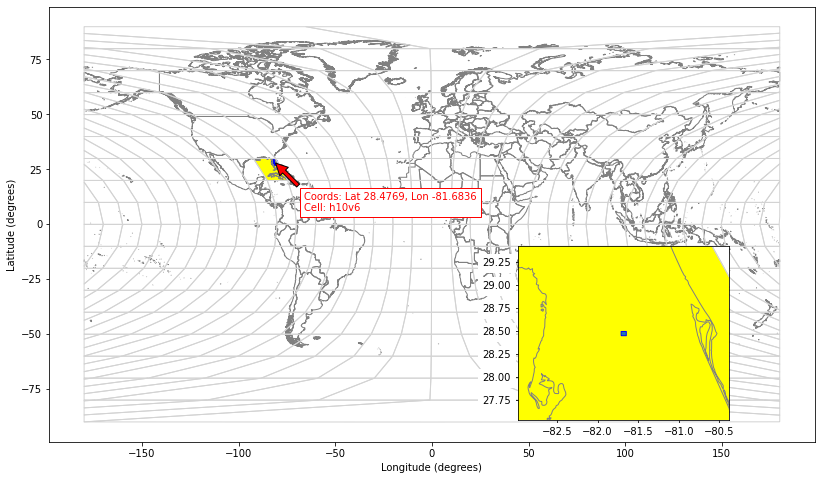

Token response: 
{'token_type': 'Bearer', 'token': 'lCbKNeCz1gY63KBC_CnZnXkfxojtf2n68E-IOX6qRp7-X_hAlxqodCVoLpuvumsc-qAHqhqJ_vg9aBGEeP0e0g', 'expiration': '2023-08-04T19:56:07Z'}
02/08/2023 19:59:02 | Task submittal response from NASA AppEEARS:

{'task_id': 'a657227b-29f0-4da4-9549-b667d4dba4ba', 'status': 'queued', 'user_id': 'craig.jariz@gmail.com', 'updated': '2023-08-02T19:59:02.513646', 'status_type': 'task'}
02/08/2023 19:59:03 | queued
02/08/2023 19:59:23 | processing
02/08/2023 19:59:43 | processing
02/08/2023 20:00:03 | done


In [7]:
# Get map for the hell of it
getMODISCoords(zone_shp)

# Create GeoJSON
zoneJSON = getZoneJSON(zone_shp)

# Open connection to data host (NASA AppEEARS)
token = openConn(api,username,password)
header = {'Authorization': 'Bearer {}'.format(token)}

# Submit job, get response
taskID,status = submitRequest(jobName,header,zoneJSON,startDate,endDate)
debugMsg("Task submittal response from NASA AppEEARS:\n")
print(status)

# Wait for data to be ready
waitInQueue(header,taskID)

In [8]:
# Download files
outFiles = downloadFiles(api,header,taskID,tempStorage)

02/08/2023 20:00:05 | Downloading file: MOD16A2.061_ET_500m_doy2021361_aid0001.tif
02/08/2023 20:00:06 | Downloading file: MOD16A2.061_ET_500m_doy2022001_aid0001.tif
02/08/2023 20:00:07 | Downloading file: MOD16A2.061_ET_500m_doy2022009_aid0001.tif
02/08/2023 20:00:08 | Downloading file: MOD16A2.061_ET_500m_doy2022017_aid0001.tif
02/08/2023 20:00:10 | Downloading file: MOD16A2.061_ET_500m_doy2022025_aid0001.tif
02/08/2023 20:00:11 | Downloading file: MOD16A2.061_ET_500m_doy2022033_aid0001.tif
02/08/2023 20:00:12 | Downloading file: MOD16A2.061_ET_500m_doy2022041_aid0001.tif
02/08/2023 20:00:13 | Downloading file: MOD16A2.061_ET_500m_doy2022049_aid0001.tif
02/08/2023 20:00:14 | Downloading file: MOD16A2.061_ET_500m_doy2022057_aid0001.tif
02/08/2023 20:00:15 | Downloading file: MOD16A2.061_ET_500m_doy2022065_aid0001.tif
02/08/2023 20:00:15 | Downloading file: MOD16A2.061_ET_500m_doy2022073_aid0001.tif
02/08/2023 20:00:17 | Downloading file: MOD16A2.061_ET_500m_doy2022081_aid0001.tif
02/0

02/08/2023 20:01:42 | Downloading file: MOD16A2-061-Statistics.csv
02/08/2023 20:01:43 | Downloading file: Test3-granule-list.txt
02/08/2023 20:01:44 | Downloading file: Test3-request.json
02/08/2023 20:01:45 | Downloading file: Test3-MOD16A2-061-metadata.xml
02/08/2023 20:01:46 | Downloading file: README.md
02/08/2023 20:01:46 | Done with downloads!


In [12]:
# Do zonal statistics on each raster, compile into pandas dataframe
results = zonalProcessing(outFiles,zone_shp)

02/08/2023 20:02:57 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2021361_aid0001.tif
02/08/2023 20:02:57 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022001_aid0001.tif
02/08/2023 20:02:57 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022009_aid0001.tif
02/08/2023 20:02:57 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022017_aid0001.tif
02/08/2023 20:02:57 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022025_aid0001.tif
02/08/2023 20:02:57 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022033_aid0001.tif
02/08/2023 20:02:57 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022041_aid0001.tif
02/08/2023 20:02:57 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m

/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022073_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022081_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022089_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022097_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022105_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022113_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022121_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m

/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022161_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022169_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022177_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022185_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022193_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022201_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022209_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m

/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022257_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022265_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022273_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022281_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022289_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022297_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022305_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m

/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis,

02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022353_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2022361_aid0001.tif
02/08/2023 20:02:58 | Processing file TempFiles/a657227b-29f0-4da4-9549-b667d4dba4ba_MOD16A2.061_ET_500m_doy2023001_aid0001.tif
02/08/2023 20:02:58 | Done processing data!


/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [13]:
# Spit out results
debugMsg("Outputting data to Excel, also printing here:")
results.to_excel("Outputs/{}.xlsx".format(taskID))
print(results.to_markdown())

# Close out program
debugMsg("Program complete!")

02/08/2023 20:03:03 | Outputting data to Excel, also printing here:
| Date       |   Value |
|:-----------|--------:|
| 2021-12-27 | 1151.46 |
| 2022-01-01 | 1171.85 |
| 2022-01-09 | 1175.09 |
| 2022-01-17 | 1164.57 |
| 2022-01-25 | 1176.71 |
| 2022-02-02 | 1195.28 |
| 2022-02-10 | 1185.24 |
| 2022-02-18 | 1180.03 |
| 2022-02-26 | 1170.65 |
| 2022-03-06 | 1191.2  |
| 2022-03-14 | 1201.95 |
| 2022-03-22 | 1194.31 |
| 2022-03-30 | 1227.64 |
| 2022-04-07 | 1213.93 |
| 2022-04-15 | 1224.59 |
| 2022-04-23 | 1215.09 |
| 2022-05-01 | 1212.62 |
| 2022-05-09 | 1199.27 |
| 2022-05-17 | 1198.96 |
| 2022-05-25 | 1221.43 |
| 2022-06-02 | 1238.34 |
| 2022-06-10 | 1239.43 |
| 2022-06-18 | 1231.65 |
| 2022-06-26 | 1239.34 |
| 2022-07-04 | 1260.78 |
| 2022-07-12 | 1244.45 |
| 2022-07-20 | 1231.44 |
| 2022-07-28 | 1240.11 |
| 2022-08-05 | 1244.95 |
| 2022-08-13 | 1245.8  |
| 2022-08-21 | 1259.42 |
| 2022-08-29 | 1282.19 |
| 2022-09-06 | 1292.32 |
| 2022-09-14 | 1311.53 |
| 2022-09-22 | 1308.54 |
| 2022-